In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [2]:
import math
import torch
import gpytorch
import pandas as pd
import random
import scipy.stats
import numpy as np
import tqdm.notebook
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from matplotlib import pyplot as plt
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Extracting datasets
datasets = ['boston', 'concrete', 'yacht', 'wine']

d, x_, y_, s, l, x, y = {}, {}, {}, {}, {}, {}, {}

for i in range(len(datasets)):
    d[i] = pd.read_csv('data_vrbound/{}/data.txt'.format(datasets[i]), 
                       delim_whitespace=True, header=None).dropna().astype(float)
    x_[i] = d[i].iloc[:,0:-1]
    y_[i] = d[i].iloc[:,-1]

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [5]:
def split_data(x, y, test_split, seed, norm=True):
    
    x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=test_split, random_state=seed)
    
    mean_y_train = y_train.mean()
    std_y_train = y_train.std()
    
    if norm:
        x_train = pd.DataFrame(x_train.values)
        x_test = pd.DataFrame(x_test.values)
        y_train = pd.DataFrame(y_train.values.reshape(-1,1))
        y_test = pd.DataFrame(y_test.values.reshape(-1,1))

        mean_x_train = x_train.mean()
        std_x_train = x_train.std()
        std_x_train[std_x_train==0] = 1
        x_train = (x_train - mean_x_train) / std_x_train
        x_test = (x_test - mean_x_train) / std_x_train
        y_train = (y_train - mean_y_train) / std_y_train

    else:
        x_train = pd.DataFrame(x_train.values)
        x_test = pd.DataFrame(x_test.values)
        y_train = pd.DataFrame(y_train.values.reshape(-1,1))
        y_test = pd.DataFrame(y_test.values.reshape(-1,1))
        scale = 1
        low = 0

    list_of_tensors = [torch.tensor(x_train[i], dtype=torch.float32) for i in x_train]
    train_x = torch.stack(list_of_tensors)
    train_x = torch.transpose(train_x, 0, 1)

    list_of_tensors = [torch.tensor(x_test[i], dtype=torch.float32) for i in x_test]
    test_x = torch.stack(list_of_tensors)
    test_x = torch.transpose(test_x, 0, 1)

    train_y = torch.tensor(y_train[0], dtype=torch.float32)
    test_y = torch.tensor(y_test[0], dtype=torch.float32)

    return train_x, test_x, train_y, test_y, mean_y_train, std_y_train

split_data(x_[2], y_[2], test_split=0.2, seed=1, norm=True)

(tensor([[ 1.6325e+00,  7.4032e-02,  1.2305e+00, -2.4559e-03,  1.2262e+00,
          -3.6112e-01],
         [ 4.7777e-02,  9.3715e-01, -3.2243e-02, -1.8014e-01,  4.6680e-01,
           1.6185e+00],
         [ 4.7777e-02,  4.6244e-01, -1.6896e+00,  3.3082e-02, -1.7715e+00,
          -1.1367e-01],
         ...,
         [ 4.7777e-02,  2.0350e-01, -1.7685e+00, -1.7083e+00, -2.1268e-01,
          -1.1035e+00],
         [ 1.6325e+00,  1.5845e+00, -3.2243e-02,  5.3061e-01, -2.1268e-01,
           1.1236e+00],
         [ 1.1381e-01,  7.4032e-02, -3.2243e-02,  2.5030e+00, -1.7715e+00,
           6.2869e-01]]),
 tensor([[ 4.7777e-02,  2.0350e-01, -1.7685e+00, -1.7083e+00, -2.1268e-01,
          -8.5603e-01],
         [ 1.1381e-01,  1.5845e+00, -1.7685e+00,  5.1284e-01, -1.8914e+00,
           8.7615e-01],
         [ 1.6325e+00,  1.5845e+00, -3.2243e-02,  5.3061e-01, -2.1268e-01,
          -6.0857e-01],
         [-1.6690e+00,  1.5845e+00, -3.2243e-02,  5.3061e-01, -2.1268e-01,
          -1.5984e

In [7]:
def gp_multifeatures(x, y, training_iter, test_split, seed, printout, exact):
    torch.manual_seed(seed)
    train_x, test_x, train_y, test_y, loc, scale = split_data(x, y, test_split, seed, norm=True)
    
    if exact:
        class ExactGPModel(gpytorch.models.ExactGP):
            def __init__(self, train_x, train_y, likelihood):
                super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

            def forward(self, x):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood)

    else:
        num_inducing = 200
        class GPModel(gpytorch.models.ApproximateGP):
            def __init__(self, inducing_points):
                variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
                variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
                super(GPModel, self).__init__(variational_strategy)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

            def forward(self, x):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#         inducing_points = train_x[:num_inducing]
        indices = torch.randperm(len(train_x))[:num_inducing]
        inducing_points = train_x[indices]
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = GPModel(inducing_points=inducing_points)
    
    
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    if exact:
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    else:
#         mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
        mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.size(0))

    loss_list = []
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(test_x)
        scaled_pred = gpytorch.distributions.MultivariateNormal(observed_pred.mean*scale + loc, observed_pred._covar*scale**2)
        lld = likelihood.log_marginal(test_y, scaled_pred).mean()

        raw_rmse = torch.sqrt(torch.mean(torch.pow((scaled_pred.mean - test_y) , 2)))

    if printout:
        print(observed_pred)
        print(test_x.size())
        print(test_y.size())
        print('pred: {}'.format(observed_pred.mean[0]))
        print('scaled_pred: {}'.format(scaled_pred.mean[0]))
        print('y_test: {}'.format(test_y[0]))

    return lld, raw_rmse, loss_list
        
training_iter = 100
test_split = 0.2
seed = 1
printout=True
exact=False

lld, raw_rmse, loss_list = gp_multifeatures(x_[0], y_[0], training_iter, test_split, seed, printout, exact)
print(lld, raw_rmse)

MultivariateNormal(loc: torch.Size([102]))
torch.Size([102, 13])
torch.Size([102])
pred: 0.8289308547973633
scaled_pred: 29.98181915283203
y_test: 28.200000762939453
tensor(-2.4934) tensor(3.6440)


In [59]:
training_iter = 100
test_split = 0.2
seed = 1
printout=True
exact=False
lld, raw_rmse, loss_list = gp_multifeatures(x_[0], y_[0], training_iter, test_split, seed, printout, exact)
print(lld, raw_rmse)

MultivariateNormal(loc: torch.Size([102]))
torch.Size([102, 13])
torch.Size([102])
pred: 0.8366654515266418
scaled_pred: 30.051422119140625
y_test: 28.200000762939453
tensor(-2.6870) tensor(3.5881)


Dataset :boston
loss: (-2.8928294, -3.3303696171118564, -2.4552892192528897), std:0.5802517533302307
raw_rmse: (2.9966097, 2.5705434919543277, 3.422675883656024), std:0.5650352835655212
Time taken: 35.10568499999954 seconds
------------------------------------
Dataset :concrete
loss: (-3.1290827, -3.169351311684707, -3.088814047812363), std:0.053402964025735855
raw_rmse: (5.276389, 4.874525317120439, 5.678252926898116), std:0.5329388380050659
Time taken: 163.80512 seconds
------------------------------------
Dataset :yacht
loss: (-0.14200374, -0.19813823767719912, -0.08586925200404477), std:0.0744437575340271
raw_rmse: (0.45839375, 0.32454079069439157, 0.5922467144554497), std:0.17751148343086243
Time taken: 25.887596999999914 seconds
------------------------------------
Dataset :wine
loss: (-0.9256605, -0.9437164393135605, -0.9076045426658096), std:0.023945217952132225
raw_rmse: (0.591921, 0.5727656233696882, 0.6110763203711566), std:0.025403207167983055
Time taken: 230.72279900000012

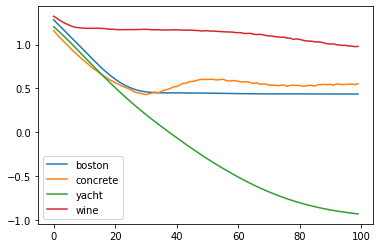

In [60]:
res = {}
# n = len(d)
n_dataset = [0, 1, 2, 3] # max 4t
itr = 10

for j in n_dataset:
    res[j] = {}
    a_1, a_2, a_3 = [], [], []
    
    tic = time.process_time()
    for i in range(itr):
        loss, raw_rmse, loss_list = gp_multifeatures(
            x_[j], y_[j], training_iter=100, 
            test_split=0.2, seed=i, 
            printout=False, exact=True)
    
        a_1.append(loss)
        a_2.append(raw_rmse)
        a_3.append(loss_list)
    
    toc = time.process_time()    
    res[j]['a_1'] = a_1
    res[j]['a_2'] = a_2
    
    print('Dataset :{}'.format(datasets[j]))
    print('loss: {}, std:{}'.format(mean_confidence_interval(a_1), np.std(a_1)))
    print('raw_rmse: {}, std:{}'.format(mean_confidence_interval(a_2), np.std(a_2)))
    loss_list_df = pd.DataFrame(a_3)
    plt.plot(loss_list_df.mean(), label=datasets[j])
    print('Time taken: {} seconds'.format(toc - tic))
    print('------------------------------------')
plt.legend()
plt.show()

Dataset :boston
loss: (-2.588122, -2.959801382248113, -2.216442399795344), std:0.2677376866340637
raw_rmse: (3.8010585, 2.1434271286415774, 5.458689932973413), std:1.1940674781799316
Time taken: 7.392409000000043 seconds
------------------------------------
Dataset :concrete
loss: (-3.5833824, -3.8179540228473443, -3.348810713328193), std:0.1689726561307907
raw_rmse: (7.2038665, 6.486332993488722, 7.921399970073289), std:0.5168721079826355
Time taken: 17.773799999999028 seconds
------------------------------------
Dataset :yacht
loss: (-2.9874835, -3.174526021863245, -2.800440981005407), std:0.13473525643348694
raw_rmse: (5.3867383, 4.5288274640515995, 6.244649136595373), std:0.6179922819137573
Time taken: 4.717306999998982 seconds
------------------------------------
Dataset :wine
loss: (-1.0126123, -1.0352868276742506, -0.9899378579946948), std:0.01633346453309059
raw_rmse: (0.5847434, 0.5532463707326918, 0.6162403903604479), std:0.02268873155117035
Time taken: 34.81011899999976 seco

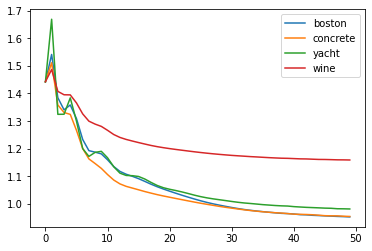

In [87]:
res = {}
# n = len(d)
n_dataset = [0,1,2,3] # max 4t
itr = 5

for j in n_dataset:
    res[j] = {}
    a_1, a_2, t, a_3 = [], [], [], []
    
    tic = time.process_time()
    for i in range(itr):
        tic = time.process_time()
        loss, raw_rmse, loss_list = gp_multifeatures(
            x_[j], y_[j], training_iter=50, 
            test_split=0.1, seed=i, 
            printout=False, exact=False)
        
        toc = time.process_time() 
        
        a_1.append(loss)
        a_2.append(raw_rmse)
        a_3.append(loss_list)
        t.append(toc - tic)
    
       
    res[j]['a_1'] = a_1
    res[j]['a_2'] = a_2
    
    print('Dataset :{}'.format(datasets[j]))
    print('loss: {}, std:{}'.format(mean_confidence_interval(a_1), np.std(a_1)))
    print('raw_rmse: {}, std:{}'.format(mean_confidence_interval(a_2), np.std(a_2)))
    loss_list_df = pd.DataFrame(a_3)
    plt.plot(loss_list_df.mean(), label=datasets[j])
    print('Time taken: {} seconds'.format(toc-tic))
    print('------------------------------------')
plt.legend()
plt.show()

In [5]:
def train_gp_model(train_x, test_x, test_y, loc, scale):
    
    class GPModel(gpytorch.models.ApproximateGP):
        def __init__(self, inducing_points):
            variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
            variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
            super(GPModel, self).__init__(variational_strategy)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())


        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    indices = torch.randperm(len(train_x))[:num_inducing]
    inducing_points = train_x[indices]
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(inducing_points=inducing_points)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

    loss_list = []
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model

In [6]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_swsgp(train_x, test_x, test_y, loc, scale, indices):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    inducing_points = train_x[indices] 
    model = GPModel(inducing_points=inducing_points)

    return model, likelihood

def optimizer_swsgp(model, mll, optimizer, train_x, train_y, num_batch):
    optimizer.zero_grad()
    output = model(train_x)
#     loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    return model

In [23]:
variational_strategy = _VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
kl = variational_strategy.kl_divergence()


NameError: name 'inducing_points' is not defined

TypeError: forward() missing 2 required positional arguments: 'variational_dist_f' and 'target'

In [7]:
# def swsgp(x, y, training_iter, test_split, seed, printout):
training_iter = 1
test_split = 0.2
num_inducing = 50
num_h = 4
num_batch = 8
seed = 1
printout=True
x, y = x_[0], y_[0]

torch.manual_seed(seed)
batch_x = np.array_split(x, num_batch)
batch_y = np.array_split(y, num_batch)

for i in range(training_iter):
    ell, kl = [], []

    for j in range(num_batch):
        train_x, test_x, train_y, test_y, loc, scale = split_data(batch_x[j], batch_y[j], test_split, seed, norm=True)
        cdist = torch.cdist(train_x, train_x).tolist()
        index_dict = {}
        
        model, likelihood = train_swsgp(train_x, test_x, test_y, loc, scale, indices)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        
        observed_pred = model(train_x)
        q = gpytorch.distributions.MultivariateNormal(observed_pred.mean, observed_pred._covar)
        ell = likelihood.expected_log_prob(train_y, q)
        
        for k in range(len(train_x)):
            indices = np.argpartition(cdist[k], num_h)[1:num_h+1]
            index_dict[k] = indices
            total_loss = sum(ell) / num_batch - sum(kl) / (num_batch * len(kl))

#         likelihood for everything in minibatch
        
        mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
        model = optimizer_swsgp(model, mll, optimizer, train_x, train_y, num_batch)

    model.train()
    likelihood.train()

NameError: name 'loss' is not defined

In [56]:
# test input indices from train
# load kernel to eval

def eval_swsgp(model, printout, test_x, test_y, scale, loc):
    
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(test_x)
        scaled_pred = gpytorch.distributions.MultivariateNormal(observed_pred.mean*scale + loc, observed_pred._covar*scale**2)
        lld = likelihood.log_marginal(test_y, scaled_pred).mean()

        raw_rmse = torch.sqrt(torch.mean(torch.pow((scaled_pred.mean - test_y) , 2)))

    if printout:
        print(observed_pred)
        print(test_x.size())
        print(test_y.size())
        print('pred: {}'.format(observed_pred.mean[0]))
        print('scaled_pred: {}'.format(scaled_pred.mean[0]))
        print('y_test: {}'.format(test_y[0]))

    # return lld, raw_rmse, loss_list

    return print(lld, raw_rmse)

eval_swsgp(model, printout, test_x, test_y, scale, loc)

MultivariateNormal(loc: torch.Size([13]))
torch.Size([13, 13])
torch.Size([13])
pred: 0.10165869444608688
scaled_pred: 17.65654754638672
y_test: 19.100000381469727
tensor(-2.9467) tensor(4.4139)
